# Poisson HMM on example session

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import PoissonHMM
from dynamax.hidden_markov_model import PoissonHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_poismodel, compute_inputs
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates, traces_over_few_sates

one = ONE()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/api.py:1465: UserWarning: Newer cache tables require ONE version 2.7 or greater
  warnings.warn(f'Newer cache tables require ONE version {min_version} or greater')


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v3 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v3_1Jul2024/' + str(bin_size) + '/'

data_path = data_path_v3

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       # var_names = ['avg_wheel_vel', 'whisker_me']
       var_names = ['avg_wheel_vel']
elif data_path == data_path_v3:
       var_names = [ 'wheel_final', 'Lick count', 'pupil_diameter', 'whisker_me',
       'left_X', 'left_Y', 'pupil_X', 'pupil_Y', 'nose_X', 'nose_Y']
       var_names = ['Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

List design matrices' eids

In [3]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [13]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}

for m, mat in enumerate(idxs[4:5]):  # [5:6]
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]
        
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer()
            normalized = normalizer.fit_transform(standardized)
            
            if len(var_names)>1:
                matrix_all[mouse_name][session] = normalized
            else:
                matrix_all[mouse_name][session] = standardized
            if 'Lick count' in var_names:
                matrix_all[mouse_name][session] = training_set
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            
        else:
            print(session)
    else:
        print(mat)

Text(0, 0.5, 'Lick count')

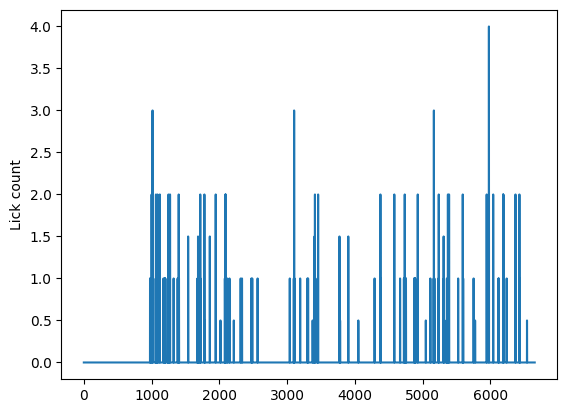

In [14]:
plt.plot(training_set)
plt.ylabel('Lick count')


## Concatenate sessions of the same animal

In [15]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Parameters

In [16]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05

num_lags = 5  # First order ARHMM
num_states = 2
kappa = 10

# Plotting params
bin_size = 0.1

In [17]:
def cross_validate_model(model, key, all_emissions, train_emissions, num_train_batches, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    #init_params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)
    init_params, props = model.initialize(key=key)

    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)])

    # Baseline model has the same number of states but random initialization
    def _fit_fold_baseline(y_train, y_val):
        return model.marginal_log_prob(init_params, y_val) # np.shape(y_val)[1]
    
    # Then actually fit the model to data
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(init_params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val) , fit_params  # np.shape(y_val)[1]
    
    # Get log likelihood without cross-validation
    def _train_ll(all_emissions):
        fit_params_non_cv, _ = model.fit_em(init_params, props, all_emissions,
                                            num_iters=num_iters, verbose=False)
        ll_train = model.marginal_log_prob(fit_params_non_cv, all_emissions)/len(all_emissions)
        return ll_train

    ll_train = _train_ll(all_emissions)
    
    val_lls, fit_params = vmap(_fit_fold)(folds, train_emissions)
    
    baseline_val_lls = vmap(_fit_fold_baseline)(folds, train_emissions)

    return val_lls, fit_params, init_params, baseline_val_lls


2


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


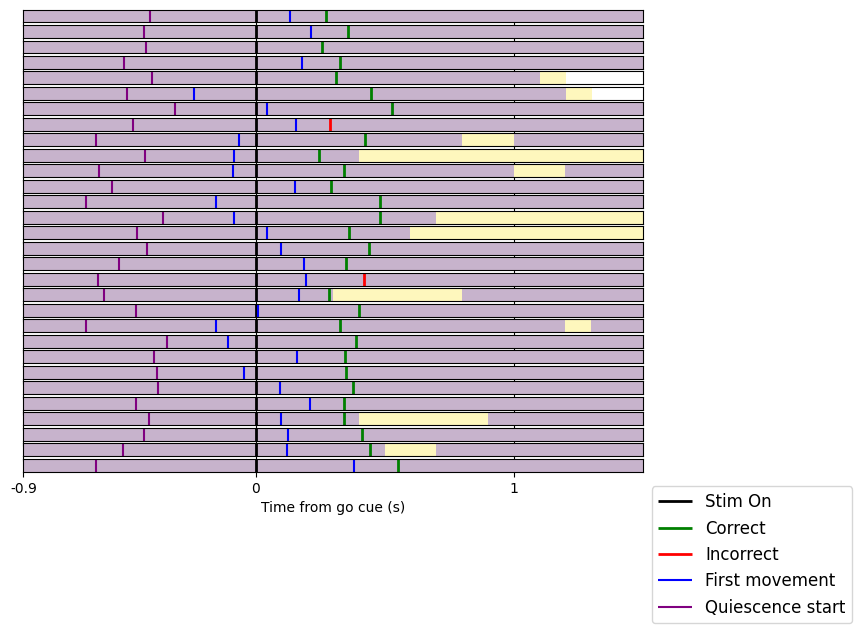

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:629: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  axs.imshow(use_normalized['most_likely_states'][None,:],


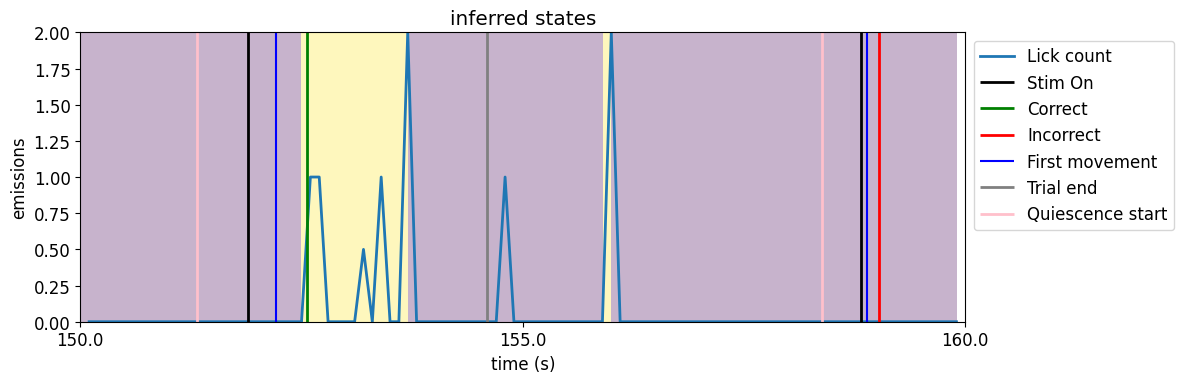

In [19]:
for m, mat in enumerate(idxs[4:5]):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
        # params, props = test_hmm.initialize(key=jr.PRNGKey(1))
        # params, lps = test_hmm.fit_em(params, props, emissions)


        # Initialize model with Kmeans
        # test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        init_params, props = test_phmm.initialize(key=jr.PRNGKey(1))  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_model(test_phmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, num_train_batches)


        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_rates = fit_params[2].rates[use_fold]     
        
        # Initialize new hmm
        new_bhmm = PoissonHMM(num_states, emission_dim)
        best_fold_params, props = new_bhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_rates=emission_rates) 
        
        # Get state estimates for validation data
        most_likely_states = new_bhmm.most_likely_states(best_fold_params, shortened_array)

        # Keep only enough states to explain 95% observations
        
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan

        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        init = -10
        end = 15
        empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)

    
        """ Stack trial states """
        trial_init = 30  # First trial to plot
        trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
        plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
        
        """ Plot raw traces over states """
        init = 1500 # First bin
        # traces_over_few_sates(init, empirical_data, session_trials, var_names)
        traces_over_few_sates(init, empirical_data, session_trials, var_names)


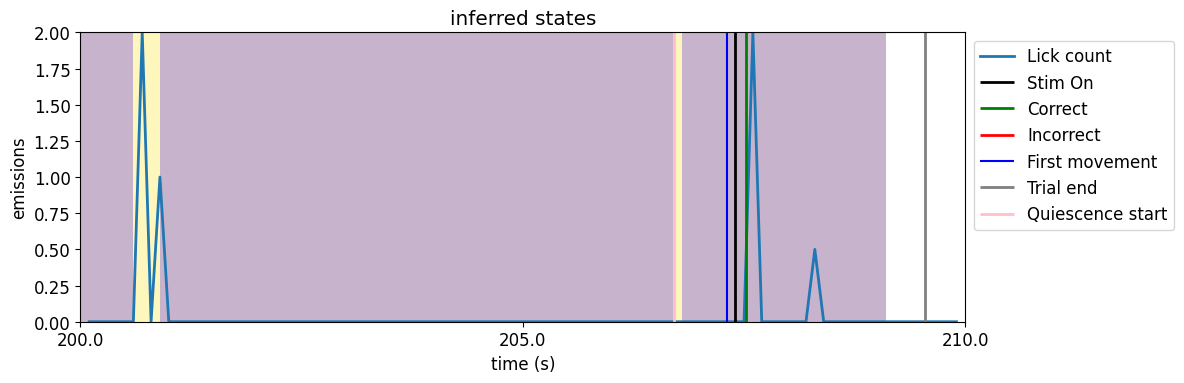

In [26]:
""" Plot raw traces over states """
init = 2000 # First bin
traces_over_few_sates(init, empirical_data, session_trials, var_names)

In [28]:
6**2*3



108